This code below creates an adjacency matrix based on an n value and k value. It will also save the matrices into their own individual csv files. There is code to save all of the times for each run into a csv file where they are logged. There is code to print images as well.

In [214]:
import numpy  as  np
import  pandas  as  pd 
from  scipy import special
import  scipy
import  scipy.linalg
import types
import math
from itertools import combinations
from timeit import default_timer as timer 
import csv
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.legend import Legend
#os.mkdir("plots")
#os.mkdir("adj_matrices")

In [2]:
gene_dat = pd.read_csv('copiedGeneData.csv',index_col='Unnamed: 0',encoding='utf-8')
matrix = gene_dat.as_matrix()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


## Spectral Analysis

In [15]:
def num_of_mutations(RDM):
    # make copy of data to not alter 
    tempRDM = np.copy(RDM)
    tempRDM = np.delete(tempRDM,-1,1)
    # list to count the number of ones
    nones = []
    nrows = RDM.shape[0]
    # for each row, sum the rows and save in list of ones
    for row in range(nrows):
        nones.append(sum(tempRDM[row,]))
    # create list of zeros by subracting the total amount of 
    # columns by the ones
    nzeros = [tempRDM.shape[1]]*(len(nones))
    nzeros = [a_i - b_i for a_i, b_i in zip(nzeros, nones)]
    # return list of ceros
    return nzeros

In [16]:
# input: matrix, list
# output: list of matrices
# Takes in a matrix and divides it into smalles matrices that 
# have the same amount of zeron in each line
def raw_data_partitions(RDM, nzeros):
    nrows = RDM.shape[0]
    ncols = RDM.shape[1]
    # variable to store matrices
    fPartitions = []
    # get unique values of the amount of zeros 
    distinct_amounts_zeros = np.unique(nzeros)
    distinct_amounts_zeros = np.sort(distinct_amounts_zeros)
    # for each amount of zeros
    for amount in distinct_amounts_zeros:
        list_amount_i = []
        # check every row if compatible with amount of zeros
        for row in range(nrows):
            if(nzeros[row]==amount):
                # and store them
                list_amount_i.append(RDM[row,])
        # to concatenate into a matrix
        Matrix_amount_i = np.concatenate(list_amount_i).reshape(len(list_amount_i), ncols)
        # and append it to the list of smaller matrices
        fPartitions.append((amount, Matrix_amount_i))
    # return list of smaller matrices
    return fPartitions

In [17]:
# input: list of tuples of float and matrix
# output: two lists of tuples of float and matrix
# Takes in a list of tuples that contain k 
# and data matrix with k zeros in each row and 
# separates them into two lists one with majority 
# zeros the other with minority zeros
def MinoritiesMajorities(dataPartition):
    Minorities = []
    Majorieties = []
    nvars = dataPartition[0][1].shape[1] - 1
    limit = np.floor(nvars/2)
    for elem in range(len(dataPartition)):
        k = dataPartition[elem][0]
        if (k > limit):
            Majorieties.append(dataPartition[elem])
        else:
            Minorities.append(dataPartition[elem])
    return Minorities, Majorieties

In [36]:
# input: one dimensional matrix (horizontal)
# output: tuple or int
# Takes in a row and categorizes the row by the amount of zeros 
# and returns the corresponding variables to the zeros 
# e.g. the row [1,0,1,0] with the columns 1234, return (2,4)
# e.g. the row [0,1,1,1] with columns 1234 returns 1
def categorize_row(row):
    # copy row to not alter the data
    tempRow = np.copy(row)
    tempRow = np.asarray(tempRow)
    # length of row without including the last column (which are the results)
    length = len(tempRow[0])-1 # minus hemoglobin
    # variable to store the variables corresponding to the zeros
    category = []
    # check line for zeros
    for i in range(length):
        if(int(tempRow[0][i]) == 0):
            category.append(i)
    # if it is only one zero in the row it returns the int
    if(len(category) != 1):
        # returns tuple of category
        return tuple(category)
    else:
        return category[0]

In [34]:
# input: tuple of int and matrix
# output: array
# Takes in a tuple of the number of zeros in the matrix and 
# the matrix and calculates f^(n, n-#0s)
def calc_f(PartitionTuple):
    # save all the variables
    k = PartitionTuple[0]
    data = PartitionTuple[1]
    nrows = data.shape[0]
    nvars = data.shape[1]-1
    # list to append the categories to
    rowCategory = []
    # for individual values the row categories are calculated
    # differently because we dont have to use the function 
    # combinations for the lexicographical order
    if(k == 1):
        f = np.zeros(int(nvars))
        lexOrder = list(range(int(nvars)))
    else:
        f = np.zeros(int(special.binom(nvars,nvars-int(k))))
        lexOrder = list(combinations(list(range(nvars)),int(k)))
    # for every row in the matrix add a category for each line
    # to rowCategory list
    for row in range(nrows):
        cat = categorize_row(data[row,])
        rowCategory.append(cat)
    # for every row in the data
    for row in range(nrows):
        # go through all the orgers
        for order in range(len(lexOrder)):
            # and check if the categories match
            if(rowCategory[row] == lexOrder[order]):
                # if they do, add the results (hemoglobin) to the data vector
                print("hello")
                f[order] = f[order] + data[row,-1]
    # return data vector
    return f

In [20]:
# input: tuple of int and matrix
# output: list of arrays
# Caluclates f^(n, n-k) for all ks and returns them 
# in a list of data vectors
def create_data_vectors(PartitionList):
    dataVectors = []
    for data in range(len(PartitionList)):
        dataVectors.append(calc_f(PartitionList[data]))
    return dataVectors

In [3]:
# input: string or list, int
# output: list of tuples
# This function returns all the combination of the characters in the string 
# of length k as a list of tuples. It can also take a list as its first 
# argument and has the same output but treats the elements of the list 
# like characters in a string. It should be noted that this function
# "renames" the function combinations of the itertools library
# so it is more readable to the user.
def alphabet_choose_k(alphabet, k):
    return list(combinations(alphabet, int(k)))

In [24]:
# input: string or list, int
# output: dictionary in which values will be assigned to certain combinations
# This function returns all the combination of the characters in the string 
# of length k as a dictionary with the corresponding values. It can also take a list as its first 
# argument and has the same output but treats the elements of the list 
# like characters in a string. It should be noted that this function
# "renames" the function combinations of the itertools library
# so it is more readable to the user.
#def dict_alphabet(alphabet, k):
#    values=list(combinations(alphabet, int(k)))
#    keys=range(len(values))
#    return dict(zip(keys,values))

In [ ]:
# input: list of same length tuples
# output: matrix
# Takes in a tuple list each of the same size k which are all the 
# combinations of our variables and calculates the adjacency matrix
# of its Johnson Graph 
def calc_adj_mat(tuple_list):
    # type check the tuple list
    if isinstance(tuple_list, list)==False:
        return("Argument is not a list!")
    # Create adjacency matrix of size of the amount of tuples in the 
    # list on both columns and rows
    dim = len(tuple_list)       
    Adj = np.zeros((dim,dim))
    # Go through the matrix 
    for i in range(dim):
        for j in range(dim):
            # if the intersection of the nodes (which are the tuples) 
            # is equal to their length - 1 then they are connected
            # and we put a one in the matrix to represent that connection
            if len(set(tuple_list[i]).intersection(set(tuple_list[j]))) == len(tuple_list[0])-1:
                Adj[i,j] = 1
    return Adj

In [22]:
# input: matrix
# output: list of floats, list of arrays
# Takes in an adjacency matrix (which is symmetric) and calculates
# the eigen values and eigen vectors and returns them as a list of floats
# and as a list of arrays respectively. It should be noted that the 
# eigen values corrspond with the same indexed eigen vectors.
# This function "renames" the function np.linalg.eigh for the
# purpose of making it easier for the user.
def calc_eig_vec_of_adj_matrix(mat):
    eig_val, eig_vec = np.linalg.eigh(mat)
    return eig_val, eig_vec

In [25]:
# input: list of floats
# output: list of arrays
# Since the eigen vectors corresponding to the same M_i in a 
# given decomposition (n,k) have the same eigen value, this
# function (that takes in eigen vectors and eigen values in 
# order of correspondance) concatenates (as matrices) eigen 
# vectors that correspond to the same M_i and returns these 
# as a list of matricies that are the basis for the M_i's
# in ascending order (i.e. [M_0, M_1,...,M_k])
def group_eig_vecs(e_vals, e_vecs):
    # gather the distinct eigen values and sort them
    distinct_vals = np.unique(e_vals.round(decimals=4))
    distinct_vals = np.sort(distinct_vals)
    # create empty list where we will store the basis
    M_basis = []
    # for every distinct eigen value we will go through the 
    # list of eigen values and if they are equal we will add the
    # corresponding eigen vector to a list 
    for val in distinct_vals:
        # list for storing eigen vectors that correspond to 
        # the same M_i
        vec_list = []
        for i in range(len(e_vals)):
            if(val == e_vals[i].round(decimals=4)):
                vec_list.append(np.transpose(e_vecs)[i])
        # transform list of arrays into matrix to append to M basis list
        vec_list = np.array(vec_list).reshape(len(vec_list), len(vec_list[0]))
        M_basis.append(vec_list)
    # return M basis
    M_basis = np.flipud(M_basis)
    return M_basis

In [26]:
# input: array, list of matrices
# output: list of arrays
# This functions calculates the projection of the data vector 
# f onto each of the M_i basis (in the form of a matrix)
def proj_f_onto_M(f, M_basis):
    # emptylist to store the f_is as we calculate them 
    f_is = []
    # for every element of the list of M basis we will 
    # calculate f_i and append it to the list
    for i in range(len(M_basis)):
        f_is.append(proj_onto_M_i(f, M_basis[i]))
    # return list of f_i's
    return f_is

# input: array, matrix
# output: array
# This function takes in a data vector and a basis for M_i and 
# projects f onto that basis to calculate f_i
def proj_onto_M_i(f, M_i):
    # get the dimensions of M_i
    nrow = M_i.shape[0]
    ncol = M_i.shape[1]
    # create a zero vector to add the projections calculated by
    # components in the eigen vectors 
    f_i = np.zeros(ncol)
    # for each row of the basis (recall we saved the eigen vectors
    # as lines) we calculare the projections
    for j in range(nrow):
        # temporarily reshape the row to transform it from an array
        # to a one dimentional matrix (vertical)
        tmp = np.copy(M_i[j])
        tmp = tmp.reshape(len(M_i[j]),1)
        # add the new projection to f_i
        f_i = f_i + project(f, tmp)
    # return f_i
    return f_i
    
# input: one dimentional matrix, array
# output: one dimentional matrix
# This funtion calculates the projection of f onto b
def project(f, v):
    # reshape v to be a one dimentional matrix compatible 
    # for dot (or inner) product (horizontal)
    v = v.reshape(1,len(v))
    # calculate projection and return it
    result = (np.dot(v,f)/np.dot(v,np.transpose(v)))*v
    return result

In [27]:
# input: list (of ints or strings) or string, list, tuple
# output: list of arrays
# Takes in a list of data vectos given a partition (n,k)
# k being the amount of zeros in a row, implements Mallow's
# method and returns a list of data vectors as arrays
def Mallows_list(alphabet, f_iList, partition):
    # partition = (n,k)
    k = partition[1]
    # first data vector f_0 does nor change 
    # so we append it intact
    MallowsList = [np.concatenate(f_iList[0])]
    # for every data vecto f_i, 0<i<k-1, implement 
    # Mallows method
    for f_iIndex in range(1,k):
        MallowsList.append(calc_Mallow(alphabet, f_iList[f_iIndex], f_iIndex, k))
    # last data vecto f_k does not change so we append it
    # without changes
    MallowsList.append(np.concatenate(f_iList[-1]))
    # return mallows list
    return MallowsList

# input: list (of ints or strings) or string, array, int
# output: array
# Takes in a data vector f_i and returns Mallow's f_i
def calc_Mallow(alphabet, f_i, i, k):
    # variables
    rows = list(combinations(alphabet, i))
    cols = alphabet_choose_k(alphabet, k)
    # zero array for storing values
    Mallow_f_i = np.zeros(len(rows))
    # T matrix just sums the values of the data vector 
    # where the values of (n choose i) (rows) is a subset
    # of the partition (n choose k) (columns)
    for iElem in range(len(rows)):
        for kElem in range(len(cols)):
            if(set(rows[iElem]).issubset(set(cols[kElem]))):
                # add elements of the data vector to 
                # Mallows data vector
                Mallow_f_i[iElem] = Mallow_f_i[iElem] + f_i[0,kElem]
    # return Maloow's data vector
    return Mallow_f_i

## Validating Functions

In [4]:
Mutations5 = np.matrix([[   0.,    1.,    0.,    0.,    0.,    1.,    1.,    1.,    1.,
           1.,    1.,    1.,    0.,  198.],
       [   0.,    1.,    1.,    0.,    0.,    1.,    0.,    0.,    1.,
           1.,    1.,    1.,    1.,  176.],
       [   0.,    1.,    1.,    1.,    0.,    0.,    1.,    0.,    1.,
           0.,    1.,    1.,    1.,  164.],
       [   0.,    1.,    0.,    0.,    1.,    0.,    0.,    1.,    1.,
           1.,    1.,    1.,    1.,  149.],
       [   0.,    1.,    0.,    0.,    1.,    0.,    0.,    1.,    1.,
           1.,    1.,    1.,    1.,  155.]])

In [37]:
zeros = num_of_mutations(Mutations5)
partTup = raw_data_partitions(Mutations5, zeros)
datavecs = create_data_vectors(partTup)
datavecs
#combs = alphabet_choose_k(list(range(13)),partTup[0][0])
#Adj = calc_adj_mat(combs)
#evals, evecs = calc_eig_vec_of_adj_matrix(Adj)
#groups = group_eig_vecs(evals, evecs)
#fs = proj_f_onto_M(datavecs[0], groups)
#Ma = Mallows_list(list(range(13)), fs, (13,5))
#Ma

hello
hello
hello
hello
hello


[array([ 0.,  0.,  0., ...,  0.,  0.,  0.])]

In [ ]:
list_times=[]
for k in range(1,7):   
    tuples = alphabet_choose_k(list(range(0, 26)), k)
    start= timer()
    Adj= calc_adj_mat(tuples)
    end = timer()
    AdjDf= pd.DataFrame(Adj)
    AdjDf.to_csv("adj_matrices/AdjDf26c%d.csv"%k, header= None, index=False)
    times = list_times.append(((26, k), end-start))
    print((26, k), end-start)
    #fig= plt.imshow(AdjDf)
    #plt.savefig("adj_matrices/AdjGraph26c%d.png"%k)
timesDf = pd.DataFrame(list_times)
timesDf.to_csv("adj_matrices/times26c1_7.csv", header=None, index=False)

(26, 1) 0.0006766320000224368
(26, 2) 0.09212516599995979
(26, 3) 5.456292970999812
(26, 4) 193.81081734699978
(26, 5) 4558.810967963


In [5]:
zero_ord=np.array([ 0.65423465,  0.65423465,  0.65423465, ...,  0.65423465,
         0.65423465,  0.65423465])

In [6]:
first_ord=np.array([ 518.15384615, -323.84615385,  178.15384615,  354.15384615,
         214.15384615,  144.15384615,  156.15384615,   16.15384615,
        -323.84615385, -159.84615385, -323.84615385, -323.84615385,
        -125.84615385])

In [7]:
sec_ord=np.array([-178.60606061,  140.84848485,  252.84848485,  163.75757576,
         119.21212121,  126.84848485,   37.75757576, -178.60606061,
         -74.24242424, -178.60606061, -178.60606061,  -52.60606061,
         -54.96969697, -118.96969697,  -68.06060606,  -42.60606061,
         -46.96969697,    3.93939394,  127.57575758,   67.93939394,
         127.57575758,  127.57575758,   55.57575758,  200.48484848,
         -52.60606061,   78.84848485,   74.48484848, -178.60606061,
         -54.96969697, -114.60606061,  -54.96969697,  -54.96969697,
          71.03030303,   59.39393939,   14.84848485,  186.48484848,
         -66.60606061, -118.96969697, -178.60606061, -118.96969697,
        -118.96969697,    7.03030303,  -74.24242424,  -66.60606061,
         148.3030303 ,  -68.06060606,   36.3030303 ,  -68.06060606,
         -68.06060606,   57.93939394,   86.84848485,   -2.24242424,
         -42.60606061,   61.75757576,  -42.60606061,  -42.60606061,
        -114.60606061,    5.39393939,  -46.96969697, -106.60606061,
         -46.96969697,  -46.96969697, -118.96969697,    3.93939394,
         108.3030303 ,    3.93939394,    3.93939394,  -68.06060606,
          67.93939394,  127.57575758,  127.57575758,   55.57575758,
          67.93939394,   67.93939394,   -4.06060606,  127.57575758,
          55.57575758,   55.57575758])

In [8]:
third_ord=np.array([ -39.16363636,  -74.36363636,  -46.36363636,  -32.36363636,
         -34.76363636,   -6.76363636,   61.23636364,   28.43636364,
          61.23636364,   61.23636364,   21.63636364,  159.9030303 ,
         -14.76363636,   69.9030303 ,   67.5030303 , -107.16363636,
         -39.16363636,  -71.96363636,  -39.16363636,  -39.16363636,
          53.23636364,   67.36969697,   34.7030303 ,  149.63636364,
         -25.03030303,  -74.36363636, -107.16363636,  -74.36363636,
         -74.36363636,   18.03636364,  -30.63030303,  -25.03030303,
         112.3030303 ,  -46.36363636,   30.16969697,  -46.36363636,
         -46.36363636,   46.03636364,   74.3030303 ,    8.96969697,
         -32.36363636,   44.16969697,  -32.36363636,  -32.36363636,
         -71.96363636,   14.56969697,  -34.76363636,  -67.56363636,
         -34.76363636,  -34.76363636,  -74.36363636,   -6.76363636,
          69.76969697,   -6.76363636,   -6.76363636,  -46.36363636,
          28.43636364,   61.23636364,   61.23636364,   21.63636364,
          28.43636364,   28.43636364,  -11.16363636,   61.23636364,
          21.63636364,   21.63636364,  -61.03030303,   21.63636364,
         -23.03030303,  -21.43030303,   61.23636364,   15.9030303 ,
          37.76969697,   15.9030303 ,   15.9030303 ,  -23.6969697 ,
         -13.56363636,    0.43636364,  -56.63030303,   26.03636364,
          39.36969697,   61.23636364,   39.36969697,   39.36969697,
          -0.23030303,   28.43636364,   26.03636364,  -47.2969697 ,
          20.7030303 ,  -12.0969697 ,   20.7030303 ,   20.7030303 ,
         -18.8969697 ,  -25.96363636,    2.03636364,   11.36969697,
         -21.43030303,   11.36969697,   11.36969697,   37.76969697,
          -0.36363636,   12.96969697,   34.83636364,   12.96969697,
          12.96969697,   39.36969697,   -5.6969697 ,  -38.4969697 ,
          -5.6969697 ,   -5.6969697 ,   20.7030303 ,  -29.16363636,
         -51.03030303,  -51.03030303,  -24.63030303,  -29.16363636,
         -29.16363636,   -2.76363636,  -51.03030303,  -24.63030303,
         -24.63030303,   18.03636364,  102.7030303 ,   45.63636364,
         -74.36363636,  -61.03030303,  -39.16363636,  -61.03030303,
         -61.03030303,   31.36969697,  -71.96363636,  -74.36363636,
         -46.36363636,   21.63636364,  -11.16363636,   21.63636364,
          21.63636364,  114.03636364,  142.3030303 ,  -32.36363636,
         -23.03030303,  -55.83030303,  -23.03030303,  -23.03030303,
         -62.63030303,  -34.76363636,  -21.43030303,    0.43636364,
         -21.43030303,  -21.43030303,  -61.03030303,   61.23636364,
          28.43636364,   61.23636364,   61.23636364,   21.63636364,
          37.76969697,   15.9030303 ,   15.9030303 ,  -23.6969697 ,
          37.76969697,   37.76969697,   -1.83030303,   15.9030303 ,
         -23.6969697 ,  -23.6969697 , -107.16363636,    7.76969697,
          35.76969697,  -13.56363636,  -46.36363636,  -13.56363636,
         -13.56363636,   78.83636364,  107.1030303 ,  -67.56363636,
           0.43636364,  -32.36363636,    0.43636364,    0.43636364,
         -39.16363636,   47.36969697,  -56.63030303,  -34.76363636,
         -56.63030303,  -56.63030303,  -96.23030303,   26.03636364,
          -6.76363636,   26.03636364,   26.03636364,  -13.56363636,
          61.23636364,   39.36969697,   39.36969697,   -0.23030303,
          61.23636364,   61.23636364,   21.63636364,   39.36969697,
          -0.23030303,   -0.23030303,  -67.56363636,   69.76969697,
          28.43636364,  104.96969697,   28.43636364,   28.43636364,
         -11.16363636,   75.36969697,   26.03636364,   -6.76363636,
          26.03636364,   26.03636364,  -13.56363636,  -47.2969697 ,
          29.23636364,  -47.2969697 ,  -47.2969697 ,  -86.8969697 ,
         -12.0969697 ,   20.7030303 ,   20.7030303 ,  -18.8969697 ,
         -12.0969697 ,  -12.0969697 ,  -51.6969697 ,   20.7030303 ,
         -18.8969697 ,  -18.8969697 ,  -93.96363636,  -25.96363636,
         -58.76363636,  -25.96363636,  -25.96363636,    0.43636364,
           2.03636364,   78.56969697,    2.03636364,    2.03636364,
          28.43636364,  -21.43030303,   11.36969697,   11.36969697,
          37.76969697,  -21.43030303,  -21.43030303,    4.96969697,
          11.36969697,   37.76969697,   37.76969697,   -0.36363636,
         -33.16363636,   -0.36363636,   -0.36363636,   26.03636364,
          34.83636364,   12.96969697,   12.96969697,   39.36969697,
          34.83636364,   34.83636364,   61.23636364,   12.96969697,
          39.36969697,   39.36969697,  -38.4969697 ,   -5.6969697 ,
          -5.6969697 ,   20.7030303 ,  -38.4969697 ,  -38.4969697 ,
         -12.0969697 ,   -5.6969697 ,   20.7030303 ,   20.7030303 ,
         -29.16363636,  -29.16363636,   -2.76363636,  -51.03030303,
         -24.63030303,  -24.63030303,  -29.16363636,   -2.76363636,
          -2.76363636,  -24.63030303])

In [9]:
fourth_ord=np.array([ -3.94523810e+01,   6.50000000e+00,  -1.65952381e+01,
         -1.58809524e+01,   3.00714286e+01,   9.83333333e+00,
          1.95952381e+01,   9.83333333e+00,   9.83333333e+00,
         -1.37380952e+01,  -1.44523810e+01,  -6.11904762e+00,
         -3.68333333e+01,   9.11904762e+00,   2.03095238e+01,
          3.00714286e+01,   2.03095238e+01,   2.03095238e+01,
         -3.26190476e+00,   1.05476190e+01,   9.11904762e+00,
         -2.85000000e+01,   1.19761905e+01,  -7.54761905e+00,
          1.19761905e+01,   1.19761905e+01,  -1.15952381e+01,
         -1.79047619e+01,  -1.23809524e+00,   7.80952381e+00,
         -1.17142857e+01,   7.80952381e+00,   7.80952381e+00,
          1.95952381e+01,  -2.66666667e+00,   8.52380952e+00,
          1.82857143e+01,   8.52380952e+00,   8.52380952e+00,
          2.03095238e+01,   1.90476190e-01,  -1.93333333e+01,
          1.90476190e-01,   1.90476190e-01,   1.19761905e+01,
         -1.02857143e+01,  -2.00476190e+01,  -2.00476190e+01,
         -8.26190476e+00,  -1.02857143e+01,  -1.02857143e+01,
          1.50000000e+00,  -2.00476190e+01,  -8.26190476e+00,
         -8.26190476e+00,   3.18571429e+01,   9.69761905e+01,
          6.62619048e+01,  -5.06428571e+01,  -3.94523810e+01,
         -2.96904762e+01,  -3.94523810e+01,  -3.94523810e+01,
          4.30476190e+01,  -4.92142857e+01,  -5.06428571e+01,
         -3.39761905e+01,   6.50000000e+00,  -1.30238095e+01,
          6.50000000e+00,   6.50000000e+00,   8.90000000e+01,
          1.20547619e+02,  -2.56428571e+01,  -1.65952381e+01,
         -3.61190476e+01,  -1.65952381e+01,  -1.65952381e+01,
         -4.01666667e+01,  -2.70714286e+01,  -1.58809524e+01,
         -6.11904762e+00,  -1.58809524e+01,  -1.58809524e+01,
         -3.94523810e+01,   3.00714286e+01,   1.05476190e+01,
          3.00714286e+01,   3.00714286e+01,   6.50000000e+00,
          1.95952381e+01,   9.83333333e+00,   9.83333333e+00,
         -1.37380952e+01,   1.95952381e+01,   1.95952381e+01,
         -3.97619048e+00,   9.83333333e+00,  -1.37380952e+01,
         -1.37380952e+01,  -7.01666667e+01,   2.26904762e+01,
          3.93571429e+01,  -1.44523810e+01,  -3.39761905e+01,
         -1.44523810e+01,  -1.44523810e+01,   6.80476190e+01,
          9.95952381e+01,  -4.65952381e+01,  -6.11904762e+00,
         -2.56428571e+01,  -6.11904762e+00,  -6.11904762e+00,
         -2.96904762e+01,   4.62619048e+01,  -3.68333333e+01,
         -2.70714286e+01,  -3.68333333e+01,  -3.68333333e+01,
         -6.04047619e+01,   9.11904762e+00,  -1.04047619e+01,
          9.11904762e+00,   9.11904762e+00,  -1.44523810e+01,
          3.00714286e+01,   2.03095238e+01,   2.03095238e+01,
         -3.26190476e+00,   3.00714286e+01,   3.00714286e+01,
          6.50000000e+00,   2.03095238e+01,  -3.26190476e+00,
         -3.26190476e+00,  -4.65952381e+01,   5.79285714e+01,
          1.05476190e+01,   7.88809524e+01,   1.05476190e+01,
          1.05476190e+01,  -1.30238095e+01,   6.29285714e+01,
          9.11904762e+00,  -1.04047619e+01,   9.11904762e+00,
          9.11904762e+00,  -1.44523810e+01,  -2.85000000e+01,
          3.98333333e+01,  -2.85000000e+01,  -2.85000000e+01,
         -5.20714286e+01,  -7.54761905e+00,   1.19761905e+01,
          1.19761905e+01,  -1.15952381e+01,  -7.54761905e+00,
         -7.54761905e+00,  -3.11190476e+01,   1.19761905e+01,
         -1.15952381e+01,  -1.15952381e+01,  -5.83809524e+01,
         -1.79047619e+01,  -3.74285714e+01,  -1.79047619e+01,
         -1.79047619e+01,  -6.11904762e+00,  -1.23809524e+00,
          6.70952381e+01,  -1.23809524e+00,  -1.23809524e+00,
          1.05476190e+01,  -1.17142857e+01,   7.80952381e+00,
          7.80952381e+00,   1.95952381e+01,  -1.17142857e+01,
         -1.17142857e+01,   7.14285714e-02,   7.80952381e+00,
          1.95952381e+01,   1.95952381e+01,  -2.66666667e+00,
         -2.21904762e+01,  -2.66666667e+00,  -2.66666667e+00,
          9.11904762e+00,   1.82857143e+01,   8.52380952e+00,
          8.52380952e+00,   2.03095238e+01,   1.82857143e+01,
          1.82857143e+01,   3.00714286e+01,   8.52380952e+00,
          2.03095238e+01,   2.03095238e+01,  -1.93333333e+01,
          1.90476190e-01,   1.90476190e-01,   1.19761905e+01,
         -1.93333333e+01,  -1.93333333e+01,  -7.54761905e+00,
          1.90476190e-01,   1.19761905e+01,   1.19761905e+01,
         -1.02857143e+01,  -1.02857143e+01,   1.50000000e+00,
         -2.00476190e+01,  -8.26190476e+00,  -8.26190476e+00,
         -1.02857143e+01,   1.50000000e+00,   1.50000000e+00,
         -8.26190476e+00,  -3.26190476e+00,  -2.63571429e+01,
         -8.07142857e+00,   2.03095238e+01,   1.76428571e+01,
          9.83333333e+00,   1.76428571e+01,   1.76428571e+01,
         -5.92857143e+00,   1.95952381e+01,   2.03095238e+01,
          1.19761905e+01,  -8.26190476e+00,   1.50000000e+00,
         -8.26190476e+00,  -8.26190476e+00,  -3.18333333e+01,
         -3.81428571e+01,   7.80952381e+00,   6.42857143e+00,
          1.61904762e+01,   6.42857143e+00,   6.42857143e+00,
          1.82142857e+01,   8.52380952e+00,   5.85714286e+00,
         -1.95238095e+00,   5.85714286e+00,   5.85714286e+00,
          1.76428571e+01,  -2.00476190e+01,  -1.02857143e+01,
         -2.00476190e+01,  -2.00476190e+01,  -8.26190476e+00,
         -1.16666667e+01,  -3.85714286e+00,  -3.85714286e+00,
          7.92857143e+00,  -1.16666667e+01,  -1.16666667e+01,
          1.19047619e-01,  -3.85714286e+00,   7.92857143e+00,
          7.92857143e+00,   3.00714286e+01,  -6.42857143e-01,
         -8.97619048e+00,   2.21428571e+00,   1.19761905e+01,
          2.21428571e+00,   2.21428571e+00,  -2.13571429e+01,
         -2.76666667e+01,   1.82857143e+01,  -1.95238095e+00,
          7.80952381e+00,  -1.95238095e+00,  -1.95238095e+00,
          9.83333333e+00,  -1.24285714e+01,   1.63333333e+01,
          8.52380952e+00,   1.63333333e+01,   1.63333333e+01,
          2.81190476e+01,  -9.57142857e+00,   1.90476190e-01,
         -9.57142857e+00,  -9.57142857e+00,   2.21428571e+00,
         -2.00476190e+01,  -1.22380952e+01,  -1.22380952e+01,
         -4.52380952e-01,  -2.00476190e+01,  -2.00476190e+01,
         -8.26190476e+00,  -1.22380952e+01,  -4.52380952e-01,
         -4.52380952e-01,   1.82857143e+01,  -1.93333333e+01,
         -1.02857143e+01,  -2.98095238e+01,  -1.02857143e+01,
         -1.02857143e+01,   1.50000000e+00,  -2.07619048e+01,
         -9.57142857e+00,   1.90476190e-01,  -9.57142857e+00,
         -9.57142857e+00,   2.21428571e+00,   1.46666667e+01,
         -4.85714286e+00,   1.46666667e+01,   1.46666667e+01,
          2.64523810e+01,   4.19047619e+00,  -5.57142857e+00,
         -5.57142857e+00,   6.21428571e+00,   4.19047619e+00,
          4.19047619e+00,   1.59761905e+01,  -5.57142857e+00,
          6.21428571e+00,   6.21428571e+00,   2.77142857e+01,
          7.47619048e+00,   1.72380952e+01,   7.47619048e+00,
          7.47619048e+00,  -1.95238095e+00,  -8.57142857e-01,
         -2.03809524e+01,  -8.57142857e-01,  -8.57142857e-01,
         -1.02857143e+01,   7.52380952e+00,  -2.23809524e+00,
         -2.23809524e+00,  -1.16666667e+01,   7.52380952e+00,
          7.52380952e+00,  -1.90476190e+00,  -2.23809524e+00,
         -1.16666667e+01,  -1.16666667e+01,  -1.42857143e-01,
          9.61904762e+00,  -1.42857143e-01,  -1.42857143e-01,
         -9.57142857e+00,  -1.06190476e+01,  -2.80952381e+00,
         -2.80952381e+00,  -1.22380952e+01,  -1.06190476e+01,
         -1.06190476e+01,  -2.00476190e+01,  -2.80952381e+00,
         -1.22380952e+01,  -1.22380952e+01,   1.36190476e+01,
          3.85714286e+00,   3.85714286e+00,  -5.57142857e+00,
          1.36190476e+01,   1.36190476e+01,   4.19047619e+00,
          3.85714286e+00,  -5.57142857e+00,  -5.57142857e+00,
          1.22380952e+01,   1.22380952e+01,   2.80952381e+00,
          2.00476190e+01,   1.06190476e+01,   1.06190476e+01,
          1.22380952e+01,   2.80952381e+00,   2.80952381e+00,
          1.06190476e+01,  -2.96904762e+01,  -6.04047619e+01,
         -1.44523810e+01,  -3.26190476e+00,   6.50000000e+00,
         -3.26190476e+00,  -3.26190476e+00,   7.92380952e+01,
          1.10785714e+02,  -6.11904762e+00,  -2.63571429e+01,
         -1.65952381e+01,  -2.63571429e+01,  -2.63571429e+01,
         -4.99285714e+01,  -3.68333333e+01,  -8.07142857e+00,
         -1.58809524e+01,  -8.07142857e+00,  -8.07142857e+00,
         -3.16428571e+01,   2.03095238e+01,   3.00714286e+01,
          2.03095238e+01,   2.03095238e+01,  -3.26190476e+00,
          9.83333333e+00,   1.76428571e+01,   1.76428571e+01,
         -5.92857143e+00,   9.83333333e+00,   9.83333333e+00,
         -1.37380952e+01,   1.76428571e+01,  -5.92857143e+00,
         -5.92857143e+00,  -6.11904762e+00,   1.05476190e+01,
          1.95952381e+01,   7.14285714e-02,   1.95952381e+01,
          1.95952381e+01,  -3.97619048e+00,   9.11904762e+00,
          2.03095238e+01,   3.00714286e+01,   2.03095238e+01,
          2.03095238e+01,  -3.26190476e+00,   1.19761905e+01,
         -7.54761905e+00,   1.19761905e+01,   1.19761905e+01,
         -1.15952381e+01,   1.50000000e+00,  -8.26190476e+00,
         -8.26190476e+00,  -3.18333333e+01,   1.50000000e+00,
          1.50000000e+00,  -2.20714286e+01,  -8.26190476e+00,
         -3.18333333e+01,  -3.18333333e+01,  -1.79047619e+01,
         -3.81428571e+01,  -2.83809524e+01,  -3.81428571e+01,
         -3.81428571e+01,  -2.63571429e+01,   7.80952381e+00,
         -1.17142857e+01,   7.80952381e+00,   7.80952381e+00,
          1.95952381e+01,   1.61904762e+01,   6.42857143e+00,
          6.42857143e+00,   1.82142857e+01,   1.61904762e+01,
          1.61904762e+01,   2.79761905e+01,   6.42857143e+00,
          1.82142857e+01,   1.82142857e+01,   8.52380952e+00,
          1.82857143e+01,   8.52380952e+00,   8.52380952e+00,
          2.03095238e+01,  -1.95238095e+00,   5.85714286e+00,
          5.85714286e+00,   1.76428571e+01,  -1.95238095e+00,
         -1.95238095e+00,   9.83333333e+00,   5.85714286e+00,
          1.76428571e+01,   1.76428571e+01,  -1.02857143e+01,
         -2.00476190e+01,  -2.00476190e+01,  -8.26190476e+00,
         -1.02857143e+01,  -1.02857143e+01,   1.50000000e+00,
         -2.00476190e+01,  -8.26190476e+00,  -8.26190476e+00,
         -1.16666667e+01,  -1.16666667e+01,   1.19047619e-01,
         -3.85714286e+00,   7.92857143e+00,   7.92857143e+00,
         -1.16666667e+01,   1.19047619e-01,   1.19047619e-01,
          7.92857143e+00,  -2.70714286e+01,  -1.04047619e+01,
          3.00714286e+01,   1.05476190e+01,   3.00714286e+01,
          3.00714286e+01,   6.50000000e+00,   8.24523810e+01,
         -6.42857143e-01,   9.11904762e+00,  -6.42857143e-01,
         -6.42857143e-01,  -2.42142857e+01,  -8.97619048e+00,
         -2.85000000e+01,  -8.97619048e+00,  -8.97619048e+00,
         -3.25476190e+01,   1.19761905e+01,   2.21428571e+00,
          2.21428571e+00,  -2.13571429e+01,   1.19761905e+01,
          1.19761905e+01,  -1.15952381e+01,   2.21428571e+00,
         -2.13571429e+01,  -2.13571429e+01,  -3.88571429e+01,
         -2.76666667e+01,  -1.79047619e+01,  -2.76666667e+01,
         -2.76666667e+01,  -1.58809524e+01,   1.82857143e+01,
         -1.23809524e+00,   1.82857143e+01,   1.82857143e+01,
          3.00714286e+01,   7.80952381e+00,  -1.95238095e+00,
         -1.95238095e+00,   9.83333333e+00,   7.80952381e+00,
          7.80952381e+00,   1.95952381e+01,  -1.95238095e+00,
          9.83333333e+00,   9.83333333e+00,  -1.24285714e+01,
         -2.66666667e+00,  -1.24285714e+01,  -1.24285714e+01,
         -6.42857143e-01,   8.52380952e+00,   1.63333333e+01,
          1.63333333e+01,   2.81190476e+01,   8.52380952e+00,
          8.52380952e+00,   2.03095238e+01,   1.63333333e+01,
          2.81190476e+01,   2.81190476e+01,   1.90476190e-01,
         -9.57142857e+00,  -9.57142857e+00,   2.21428571e+00,
          1.90476190e-01,   1.90476190e-01,   1.19761905e+01,
         -9.57142857e+00,   2.21428571e+00,   2.21428571e+00,
         -2.00476190e+01,  -2.00476190e+01,  -8.26190476e+00,
         -1.22380952e+01,  -4.52380952e-01,  -4.52380952e-01,
         -2.00476190e+01,  -8.26190476e+00,  -8.26190476e+00,
         -4.52380952e-01,  -2.21904762e+01,   1.82857143e+01,
         -1.23809524e+00,   1.82857143e+01,   1.82857143e+01,
          3.00714286e+01,  -1.93333333e+01,   4.90000000e+01,
         -1.93333333e+01,  -1.93333333e+01,  -7.54761905e+00,
         -2.98095238e+01,  -1.02857143e+01,  -1.02857143e+01,
          1.50000000e+00,  -2.98095238e+01,  -2.98095238e+01,
         -1.80238095e+01,  -1.02857143e+01,   1.50000000e+00,
          1.50000000e+00,  -2.07619048e+01,  -4.02857143e+01,
         -2.07619048e+01,  -2.07619048e+01,  -8.97619048e+00,
          1.90476190e-01,  -9.57142857e+00,  -9.57142857e+00,
          2.21428571e+00,   1.90476190e-01,   1.90476190e-01,
          1.19761905e+01,  -9.57142857e+00,   2.21428571e+00,
          2.21428571e+00,  -4.85714286e+00,   1.46666667e+01,
          1.46666667e+01,   2.64523810e+01,  -4.85714286e+00,
         -4.85714286e+00,   6.92857143e+00,   1.46666667e+01,
          2.64523810e+01,   2.64523810e+01,   4.19047619e+00,
          4.19047619e+00,   1.59761905e+01,  -5.57142857e+00,
          6.21428571e+00,   6.21428571e+00,   4.19047619e+00,
          1.59761905e+01,   1.59761905e+01,   6.21428571e+00,
          2.77142857e+01,   8.19047619e+00,   2.77142857e+01,
          2.77142857e+01,   1.82857143e+01,   1.72380952e+01,
          7.47619048e+00,   7.47619048e+00,  -1.95238095e+00,
          1.72380952e+01,   1.72380952e+01,   7.80952381e+00,
          7.47619048e+00,  -1.95238095e+00,  -1.95238095e+00,
         -2.03809524e+01,  -8.57142857e-01,  -8.57142857e-01,
         -1.02857143e+01,  -2.03809524e+01,  -2.03809524e+01,
         -2.98095238e+01,  -8.57142857e-01,  -1.02857143e+01,
         -1.02857143e+01,   7.52380952e+00,   7.52380952e+00,
         -1.90476190e+00,  -2.23809524e+00,  -1.16666667e+01,
         -1.16666667e+01,   7.52380952e+00,  -1.90476190e+00,
         -1.90476190e+00,  -1.16666667e+01,   9.61904762e+00,
         -1.42857143e-01,  -1.42857143e-01,  -9.57142857e+00,
          9.61904762e+00,   9.61904762e+00,   1.90476190e-01,
         -1.42857143e-01,  -9.57142857e+00,  -9.57142857e+00,
         -1.06190476e+01,  -1.06190476e+01,  -2.00476190e+01,
         -2.80952381e+00,  -1.22380952e+01,  -1.22380952e+01,
         -1.06190476e+01,  -2.00476190e+01,  -2.00476190e+01,
         -1.22380952e+01,   1.36190476e+01,   1.36190476e+01,
          4.19047619e+00,   3.85714286e+00,  -5.57142857e+00,
         -5.57142857e+00,   1.36190476e+01,   4.19047619e+00,
          4.19047619e+00,  -5.57142857e+00,   1.22380952e+01,
          2.80952381e+00,   2.80952381e+00,   1.06190476e+01,
          2.80952381e+00])

In [236]:
# getting the exact gene names from csv file without the 'outcome' column
# puts names into a list 
gene_dat_no_outcome=(gene_dat.drop(['outcome'],axis=1))
gene_names=list(gene_dat_no_outcome.columns.values)
#gene_names

In [198]:
# input: list of gene names, number of how many partitions are wanted
# output: returns a list of lists. Each list within corresponds to a particular parititoning and the combinations

def create_list_names(gene_names,k):
    list_gene_names=[]
    # will want to do 1 partition to k+1 since k needs to be included too
    for i in range(1,k+1):
        list_gene_names.append(alphabet_choose_k(gene_names,i))
    return list_gene_names

In [199]:
# input: list (essentially the list that contains partitioning lists)
# output: a dictionary which has a key for each list.
# ex: key->'1': value->list of 1st partitioning; key->2: value->list of 2nd partitioning ect.
def dict_names(list_names):
    keys=range(1,len(list_names)+1)
    #print(keys)
    return (dict(zip(keys,list_names)))

In [239]:
list_names=create_list_names(gene_names,3)
#list_names
diction=dict_names(list_names)
#diction

Link to help of where i got code to get n max values: https://stackoverflow.com/questions/5807047/efficient-way-to-take-the-minimum-maximum-n-values-and-indices-from-a-matrix-usi

In [228]:
# input: np.array of values (mallow vectors), number corresponding to # of max values wanting to find
# output: returns a list of indices which contain max vals
def get_n_max(values,n):
    indices = values.ravel().argsort()[-n:]
    top_ind=[i for i in indices]
    top_ind.reverse()
    return top_ind

In [262]:
# input: np.array of values (mallow vectors), number corresponding to # of min values wanting to find
# output: returns a list of indices which contain min vals
def get_n_min(values,n):
    indices = values.ravel().argsort()[:n]
    bot_ind=[i for i in indices]
    return bot_ind

In [203]:
#a=get_n_min(np.array([2,3,4,5,-1]),2)
#a

Got the below code from https://stackoverflow.com/questions/1012185/in-python-how-do-i-index-a-list-with-another-list

In [230]:
# input: dictionary, a list of indices for max values, int for # of partitioning of wanting extraction
# output: list of names which correspond to particular combinations of genes (lexigraphical ordering is assumed)
def retrieve_peak_names(diction,top_vals,partition):
    # dictionary.get(particular partitioning)[only the string]
    # goes through the dictionary and extracts based on "key".
    # for loop goes through the list of values which should be the max values
    # reversed the top_vals since indices go from greatest-least
    return [diction.get(partition)[i] for i in top_vals]

In [ ]:
def color_peaks(MallowTuple, n_max_peak, n_min_peak):
    top_vals=get_n_max(MallowTuple[1])
    min_vals=get_n_max(MallowTuple[1])
    peak_gene_names=retrieve_peak_names(diction, top_vals, partition)

In [273]:
# BE CAREFUL: make sure input of get_n_max (np.array) corresponds to the order
# ex: get_n_max(4th order,#max vals)
#     retrieve_peak_names(dictionary, top values from get_n_max, 4<- 4th order (place in dictionary 
#      in which we need to go into that particular list and extract those exact top value gene combinations))
top_vals=get_n_max(sec_ord,3)
print(type(top_vals[0]))

top_min_vals=get_n_min(first_ord,3)
print(top_min_vals)

peak_gene_names=retrieve_peak_names(diction,top_vals,1)
peak_gene_names

<class 'numpy.int64'>
[1, 8, 10]


[('rs58696423',), ('rs149306391',), ('rs4149433',)]

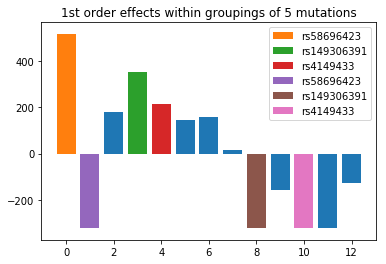

In [284]:
x_axis_1 = np.arange(len(first_ord))

plt.bar(x_axis_1,first_ord, align='center')
plt.title('1st order effects within groupings of 5 mutations')
plt.ylim((min(first_ord)-50),(max(first_ord)+50))
for i in range(len(top_vals)):
    plt.bar(top_vals[i],first_ord[top_vals[i]], align='center',label=peak_gene_names[i][0])
for j in range(len(top_min_vals)):
    plt.bar(top_min_vals[j],first_ord[top_min_vals[j]], align='center',label=peak_gene_names[j][0])
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig("plots/FirstOrder_13_5.png",bbox_inches="tight")
plt.show()

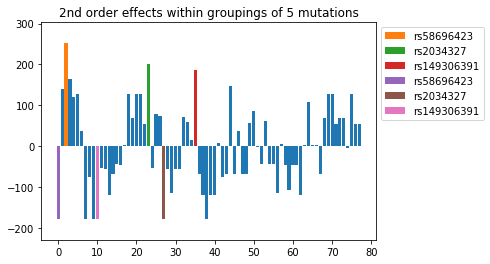

In [271]:
x_axis_2 = np.arange(len(sec_ord))

plt.bar(x_axis_2,sec_ord, align='center')
plt.title('2nd order effects within groupings of 5 mutations')
plt.ylim((min(sec_ord)-50),(max(sec_ord)+50))
for i in range(len(top_vals)):
    plt.bar(top_vals[i],sec_ord[top_vals[i]], align='center',label=peak_gene_names[i][0])
for j in range(len(top_min_vals)):
    plt.bar(top_min_vals[j],sec_ord[top_min_vals[j]], align='center',label=peak_gene_names[j][0])
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig("plots/SecondOrder_13_5.png",bbox_inches="tight")
plt.show()